# MediaPipe Face Mesh Matching

## Setup

In [1]:
from utils import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from typing import Optional

print(f"Using device: {device}")

Using device: cuda


## Load Images

Image 1 shape: (512, 512, 3)
Image 2 shape: (512, 512, 3)


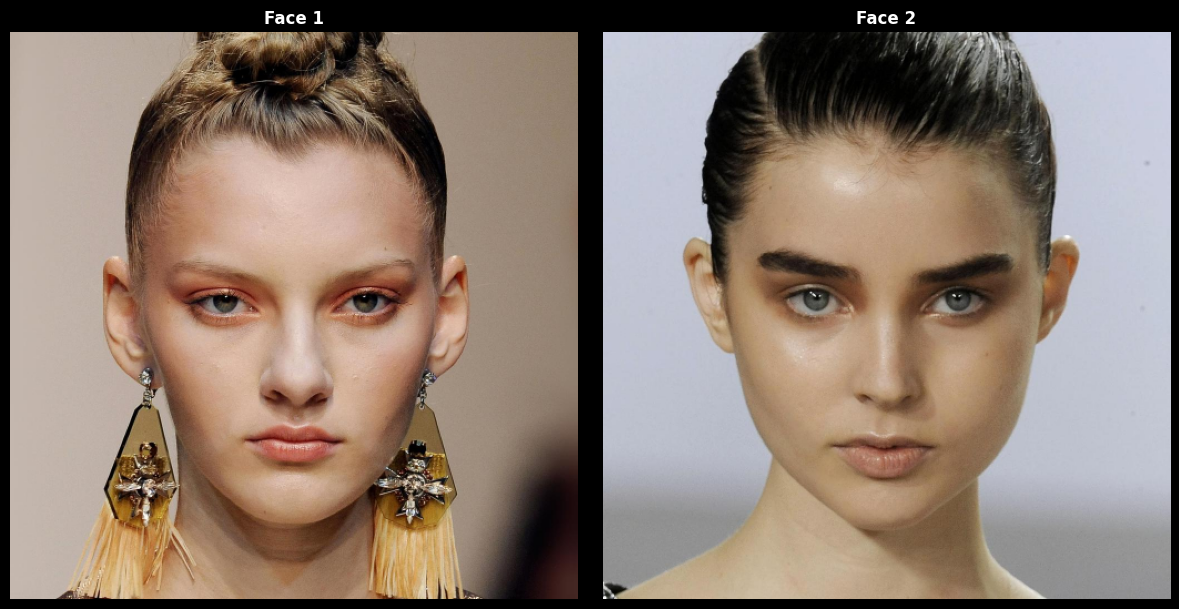

In [2]:
# Load the same pair of images as in keypoint matching
img1, img2 = load_face_pair(id1=7, id2=169, target_size=(512, 512))

print(f"Image 1 shape: {img1.shape}")
print(f"Image 2 shape: {img2.shape}")

# Visualize the pair
visualize_image_pair(img1, img2, "Face 1", "Face 2")

## MediaPipe Face Mesh Class

In [3]:
class MediaPipeFaceMatcher:
    def __init__(self, static_mode=True, max_faces=1, refine_landmarks=True):
        self.mp_face_mesh = mp.solutions.face_mesh
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=static_mode,
            max_num_faces=max_faces,
            refine_landmarks=refine_landmarks,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
    
    def extract_landmarks(self, image):
        h, w = image.shape[:2]
        results = self.face_mesh.process(image)
        if not results.multi_face_landmarks:
            print("No face detected")
            return None
        face_landmarks = results.multi_face_landmarks[0]
        landmarks = []
        for landmark in face_landmarks.landmark:
            x = landmark.x * w
            y = landmark.y * h
            landmarks.append([x, y])
        landmarks = np.array(landmarks, dtype=np.float32)
        print(f"Extracted {len(landmarks)} landmarks")
        return landmarks
    
    def get_corresponding_points(self, img1, img2):
        pts1 = self.extract_landmarks(img1)
        pts2 = self.extract_landmarks(img2)
        if pts1 is None or pts2 is None:
            raise ValueError("Failed to detect face in one or both images")
        return pts1, pts2
    
    def visualize_landmarks(self, image, landmarks, connections=True):
        img_copy = image.copy()
        for x, y in landmarks:
            cv2.circle(img_copy, (int(x), int(y)), 1, (0, 255, 0), -1)
        if connections:
            face_oval = self.mp_face_mesh.FACEMESH_FACE_OVAL
            for connection in face_oval:
                pt1 = landmarks[connection[0]].astype(int)
                pt2 = landmarks[connection[1]].astype(int)
                cv2.line(img_copy, tuple(pt1), tuple(pt2), (0, 255, 0), 1)
            lips = self.mp_face_mesh.FACEMESH_LIPS
            for connection in lips:
                pt1 = landmarks[connection[0]].astype(int)
                pt2 = landmarks[connection[1]].astype(int)
                cv2.line(img_copy, tuple(pt1), tuple(pt2), (0, 0, 255), 1)
            left_eye = self.mp_face_mesh.FACEMESH_LEFT_EYE
            right_eye = self.mp_face_mesh.FACEMESH_RIGHT_EYE
            for connection in left_eye:
                pt1 = landmarks[connection[0]].astype(int)
                pt2 = landmarks[connection[1]].astype(int)
                cv2.line(img_copy, tuple(pt1), tuple(pt2), (255, 0, 0), 1)
            for connection in right_eye:
                pt1 = landmarks[connection[0]].astype(int)
                pt2 = landmarks[connection[1]].astype(int)
                cv2.line(img_copy, tuple(pt1), tuple(pt2), (255, 0, 0), 1)
        return img_copy
    
    def compute_optical_flow(self, pts1, pts2):
        flow = pts2 - pts1
        avg_flow = np.mean(np.linalg.norm(flow, axis=1))
        max_flow = np.max(np.linalg.norm(flow, axis=1))
        print(f"Average displacement: {avg_flow:.2f} pixels")
        print(f"Maximum displacement: {max_flow:.2f} pixels")
        return flow
    
    def visualize_flow(self, image, pts1, flow, scale=2.0, step=10):
        img_copy = image.copy()
        for i in range(0, len(pts1), step):
            pt1 = pts1[i].astype(int)
            pt2 = (pts1[i] + flow[i] * scale).astype(int)
            cv2.arrowedLine(img_copy, tuple(pt1), tuple(pt2), (0, 255, 255), 1, tipLength=0.3)
        return img_copy
    
    def close(self):
        self.face_mesh.close()

## Extract Landmarks

In [4]:
mp_matcher = MediaPipeFaceMatcher()

mp_pts1 = mp_matcher.extract_landmarks(img1)
mp_pts2 = mp_matcher.extract_landmarks(img2)

if mp_pts1 is None or mp_pts2 is None:
    raise ValueError("Failed to detect faces")

Extracted 478 landmarks
Extracted 478 landmarks


I0000 00:00:1765930702.486222   75328 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765930702.526188   75493 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.195.03), renderer: NVIDIA GeForce RTX 5070 Ti/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765930702.532382   75474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765930702.543398   75492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765930702.545531   75477 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


## Visualize Landmarks

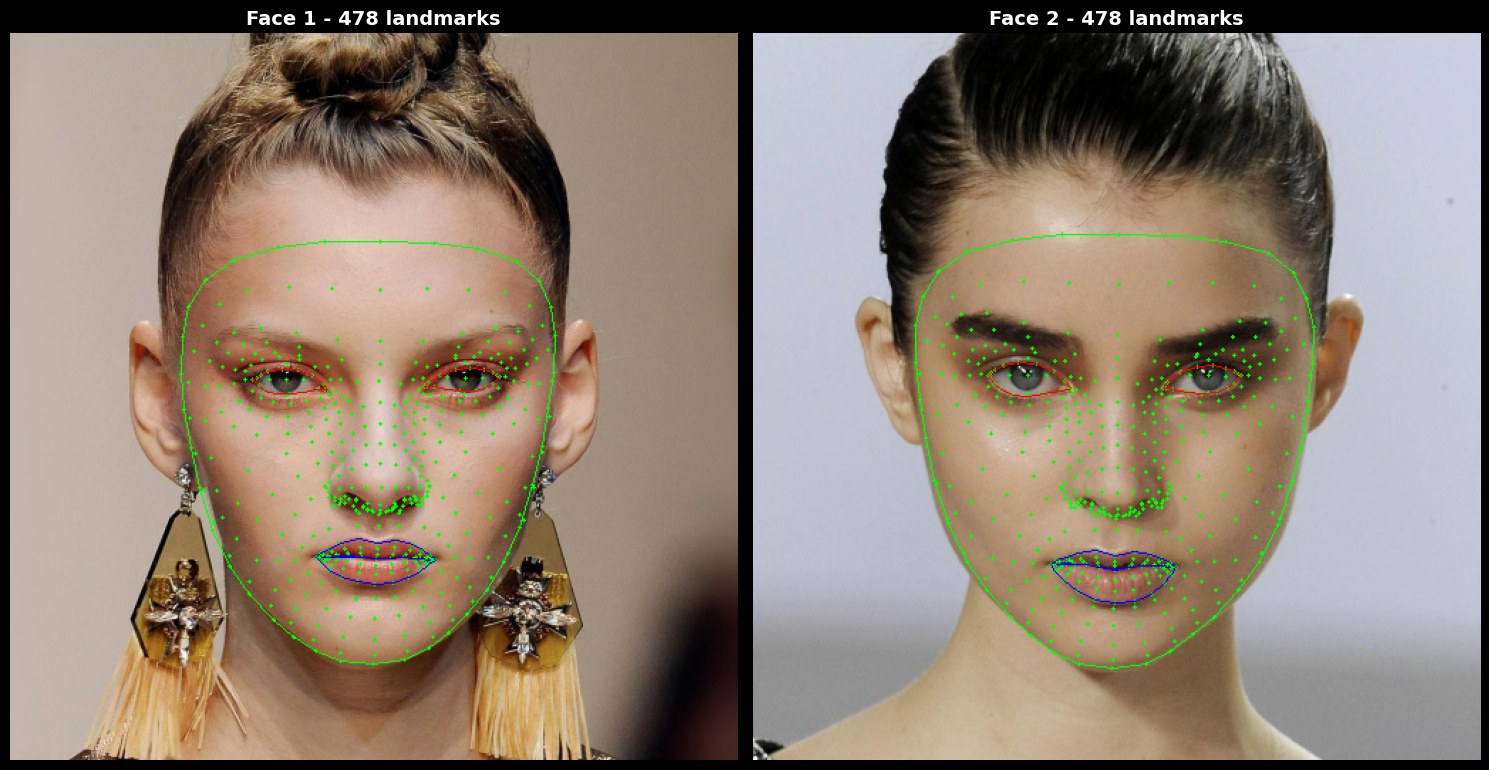

In [5]:
img1_landmarks = mp_matcher.visualize_landmarks(img1, mp_pts1, connections=True)
img2_landmarks = mp_matcher.visualize_landmarks(img2, mp_pts2, connections=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(img1_landmarks)
axes[0].set_title(f'Face 1 - {len(mp_pts1)} landmarks', fontweight='bold', fontsize=14)
axes[0].axis('off')
axes[1].imshow(img2_landmarks)
axes[1].set_title(f'Face 2 - {len(mp_pts2)} landmarks', fontweight='bold', fontsize=14)
axes[1].axis('off')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'mediapipe_landmarks.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualize Correspondences

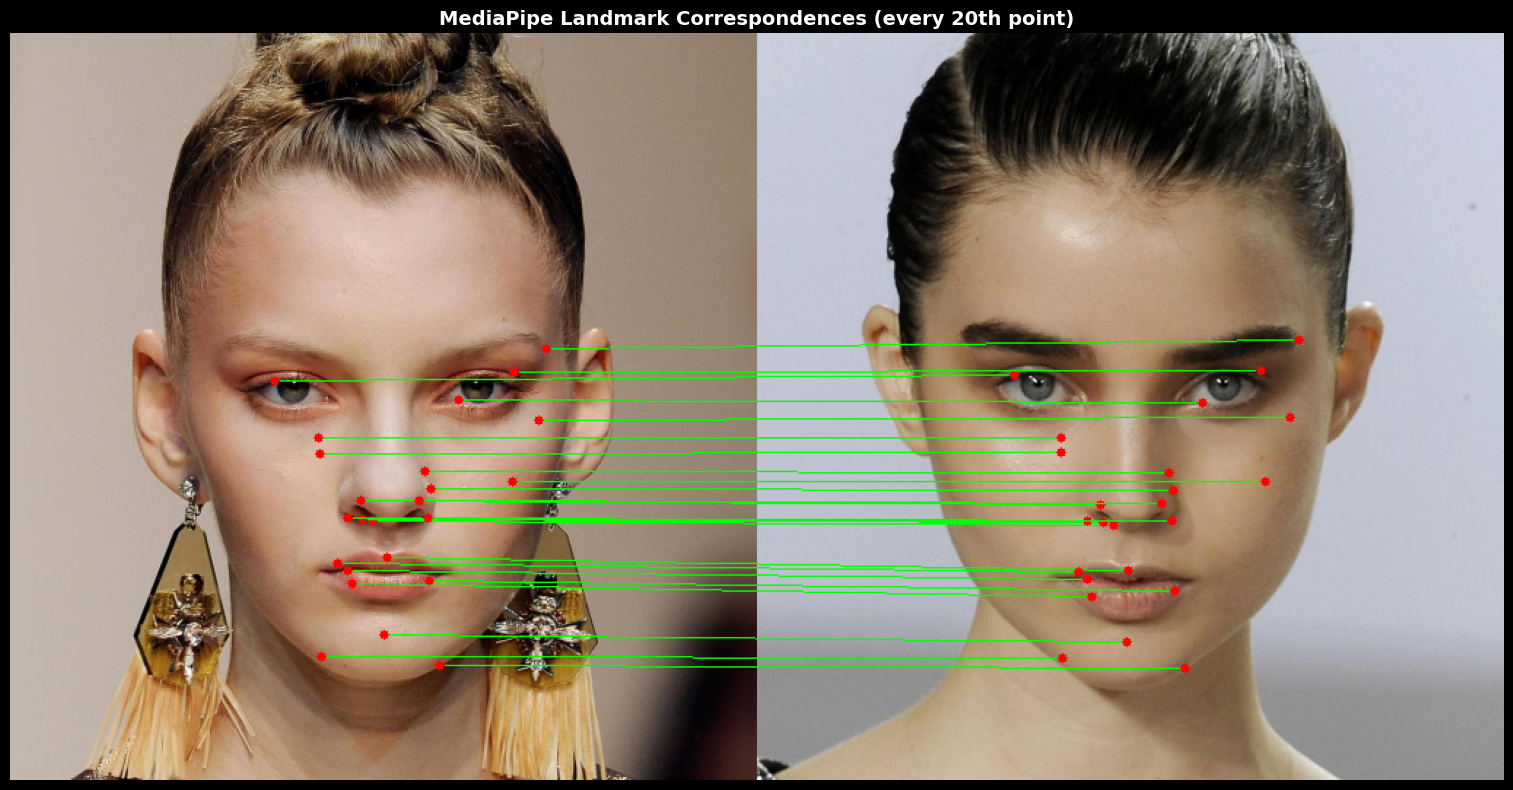

In [6]:
def visualize_correspondences(img1, pts1, img2, pts2, step=20):
    h, w = img1.shape[:2]
    combined = np.hstack([img1, img2])
    for i in range(0, len(pts1), step):
        pt1 = pts1[i].astype(int)
        pt2 = (pts2[i] + np.array([w, 0])).astype(int)
        cv2.line(combined, tuple(pt1), tuple(pt2), (0, 255, 0), 1)
        cv2.circle(combined, tuple(pt1), 3, (255, 0, 0), -1)
        cv2.circle(combined, tuple(pt2), 3, (255, 0, 0), -1)
    return combined

correspondences = visualize_correspondences(img1, mp_pts1, img2, mp_pts2, step=20)

plt.figure(figsize=(18, 8))
plt.imshow(correspondences)
plt.title('MediaPipe Landmark Correspondences (every 20th point)', fontweight='bold', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'mediapipe_correspondences.png', dpi=150, bbox_inches='tight')
plt.show()

## Compute Optical Flow

In [7]:
# Compute optical flow
print("\n" + "="*80)
print("OPTICAL FLOW COMPUTATION")
print("="*80)

mp_flow = mp_matcher.compute_optical_flow(mp_pts1, mp_pts2)


OPTICAL FLOW COMPUTATION
Average displacement: 5.41 pixels
Maximum displacement: 16.94 pixels


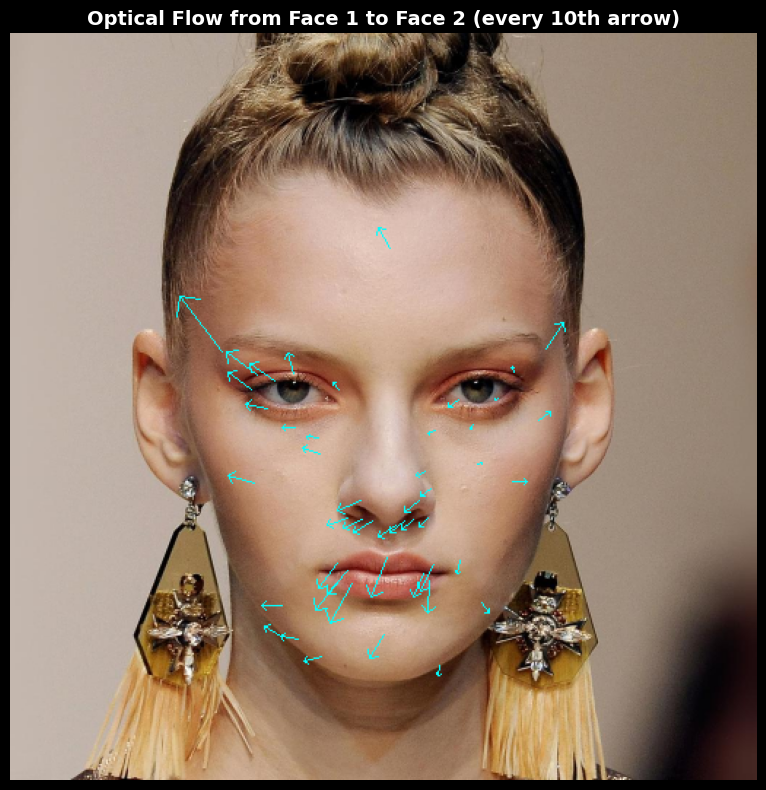

✓ Saved optical flow to ../../Report/results/mediapipe_optical_flow.png


In [8]:
# Visualize optical flow
flow_viz = mp_matcher.visualize_flow(img1, mp_pts1, mp_flow, scale=3.0, step=10)

plt.figure(figsize=(12, 8))
plt.imshow(flow_viz)
plt.title('Optical Flow from Face 1 to Face 2 (every 10th arrow)', fontweight='bold', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'mediapipe_optical_flow.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved optical flow to {RESULTS_DIR / 'mediapipe_optical_flow.png'}")

## Calculate RMSE

In [9]:
mp_rmse = calculate_rmse(mp_pts1, mp_pts2)

print(f"Number of landmarks: {len(mp_pts1)}")
print(f"Alignment RMSE: {mp_rmse:.2f} pixels")

Number of landmarks: 478
Alignment RMSE: 6.20 pixels


## Save Results

In [10]:
import pickle

mediapipe_results = {
    'landmarks': len(mp_pts1),
    'rmse': mp_rmse,
    'points1': mp_pts1,
    'points2': mp_pts2,
    'flow': mp_flow
}

with open(RESULTS_DIR / 'mediapipe_results.pkl', 'wb') as f:
    pickle.dump(mediapipe_results, f)

mp_matcher.close()

### Analysis

MediaPipe Face Mesh provides 478 dense semantic landmarks with consistent ordering across images, achieving excellent alignment (RMSE: 6.20 pixels). Unlike classical keypoint detectors, it covers the entire face including smooth regions like cheeks and forehead, eliminating the need for descriptor matching since corresponding landmarks share the same index. The neural network-based approach handles varying pose, expression, and lighting robustly, making it ideal for face-specific applications like morphing, AR effects, and expression transfer. While slower than ORB (0.12s vs 0.014s), the dense correspondence and semantic meaning provide 29x better geometric accuracy than ORB and succeed where SIFT completely fails. The method is production-ready but face-specific and cannot generalize to non-face objects.